imprements by https://www.kaggle.com/code/awsaf49/birdclef23-effnet-fsr-cutmixup-train

# Impoert library

In [1]:
import os
import random
from glob import glob
from pathlib import Path
import yaml
from tqdm import tqdm
import IPython.display as ipd

import numpy as np
import pandas as pd

import matplotlib as mpl
cmap = mpl.cm.get_cmap('coolwarm')
import matplotlib.pyplot as plt

import librosa
import wandb
from sklearn import metrics

import torch
from torch import nn
from torch.nn import functional as F
from torch.cuda.amp import autocast, GradScaler

from timm.scheduler import CosineLRScheduler

In [2]:
from config import CFG
from pytorch_model import BirdCLEF23Net
from pytorch_wav2logmel import Wav2Logmel
import pytorch_modeler as modeler
import pytorch_preprocessing_oof as prep
import common as com

In [3]:
modeler.set_seed(CFG.seed)
# setting
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print('Debug :', CFG.debug)

cuda:0
Debug : False


# Wandb

In [4]:
# Try to get the API key from Kaggle secrets
try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("WANDB")
    # Login to wandb with the API key
    wandb.login(key=api_key)
    print('kaggle notebook mode')
except:
    key_path = '/kaggle/input/wandb_key.txt'
    p = Path(key_path)
    api_key = p.read_text()
    wandb.login(key=api_key)
    print('local mode')

wandb: Currently logged in as: hirokin1999. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


local mode


In [5]:
from datetime import datetime
import pytz

# 日本時間のタイムゾーンを設定
jst = pytz.timezone('Asia/Tokyo')

# 現在時刻を取得し、日本時間に変換
now = datetime.now(jst)

# 現在時刻を文字列に変換
now_str = now.strftime('%Y-%m-%d %H:%M:%S')

print(now_str)

2023-05-10 20:42:55


In [6]:
import yaml
from tqdm import tqdm

def wandb_init(fold):
    config = {k: v for k, v in dict(vars(CFG)).items() if '__' not in k}
    config.update({"fold": int(fold)})
    yaml.dump(config, open(f'./config fold-{fold}.yaml', 'w'), )
    config = yaml.load(open(f'./config fold-{fold}.yaml', 'r'), Loader=yaml.FullLoader)
    run = wandb.init(project="birdclef-2023-public",
                     name=f"fold-{fold}|dim-{CFG.img_size[1]}x{CFG.img_size[0]}|model-{CFG.model_name}|{now_str}",
                     config=config,
                     group=CFG.comment,
                     save_code=True, )
    return run


def log_wandb(valid_df):
    save_df = valid_df.query("miss==True")
    save_df.loc[:, 'pred_name'] = save_df.pred.map(CFG.label2name)
    save_df.loc[:, 'target_name'] = save_df.target.map(CFG.label2name)
    if CFG.debug:
        save_df = save_df.iloc[:CFG.batch_size * CFG.valid_bs]
    noimg_cols = [*CFG.tab_cols, 'target', 'pred', 'target_name', 'pred_name']
    save_df = save_df.loc[:, noimg_cols]

    data = []
    for idx, row in tqdm(save_df.iterrows(), total=len(save_df), desc='wandb ', position=0, leave=True):
        filepath = '/kaggle/input/birdclef-2023/train_audio/' + row.filename
        audio, sr = librosa.load(filepath, sr=None)
        data += [[*row.tolist(), wandb.Audio(audio, caption=row.filename, sample_rate=sr)]]
    wandb_table = wandb.Table(data=data, columns=[*noimg_cols, 'audio'])
    wandb.log({'best': scores,
               'table': wandb_table,
               })

# Data Frame

In [7]:
df = pd.read_csv(f'{CFG.BASE_PATH}/train_metadata.csv')
filename = df.filename.str.replace('.ogg', '.wav')
df['filepath'] = CFG.BASE_PATH + '/train_audio_wav/' + filename
df['target'] = df.primary_label.map(CFG.name2label)
df.head(2)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,filepath,target
0,abethr1,[],['song'],4.3906,38.2788,Turdus tephronotus,African Bare-eyed Thrush,Rolf A. de By,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/128013,abethr1/XC128013.ogg,/kaggle/input/birdclef-2023/train_audio_wav/ab...,0
1,abethr1,[],['call'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363501,abethr1/XC363501.ogg,/kaggle/input/birdclef-2023/train_audio_wav/ab...,0


In [8]:
# Import required packages
from sklearn.model_selection import StratifiedKFold

# Initialize the StratifiedKFold object with 5 splits and shuffle the data
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=CFG.seed)

# Reset the index of the dataframe
df = df.reset_index(drop=True)

# Create a new column in the dataframe to store the fold number for each row
df["fold"] = -1

# Iterate over the folds and assign the corresponding fold number to each row in the dataframe
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['primary_label'])):
    df.loc[val_idx, 'fold'] = fold

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


# Visualizer

In [9]:
def plot_batch(batch, row=3, col=3, label2name=None,):
    """Plot one batch data"""
    if isinstance(batch, tuple) or isinstance(batch, list):
        audios, tars = batch
    else:
        audios = batch
        tars = None
    plt.figure(figsize=(col*5, row*3))
    for idx in range(row*col):
        ax = plt.subplot(row, col, idx+1)
        plt.plot(audios[idx].numpy(), color=cmap(0.1))
        if tars is not None:
            label = tars[idx].numpy().argmax()
            name = label2name[label]
            plt.title(name)
    plt.tight_layout()
    plt.show()
    
    
def plot_history(history):
    """Plot trainign history, credit: @cdeotte"""
    epochs = len(history.history['auc'])
    plt.figure(figsize=(15,5))
    plt.plot(np.arange(epochs),history.history['auc'],'-o',label='Train AUC',color='#ff7f0e')
    plt.plot(np.arange(epochs),history.history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
    x = np.argmax( history.history['val_auc'] ); y = np.max( history.history['val_auc'] )
    xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
    plt.ylabel('AUC (PR)',size=14); plt.xlabel('Epoch',size=14)
    plt.legend(loc=2)
    plt2 = plt.gca().twinx()
    plt2.plot(np.arange(epochs),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
    plt2.plot(np.arange(epochs),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
    x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
    plt.ylabel('Loss',size=14)
    plt.title('Fold %i - Training Plot'%(fold+1),size=18)
    plt.legend(loc=3)
    plt.show()  

In [10]:
oof_df = pd.read_csv('/kaggle/working/WSL/exp18_exp10_wsl/oof.csv')

# Training

In [11]:
import gc
def gc_collect():
    gc.collect()
    torch.cuda.empty_cache()

In [12]:
def drop_weight(weight):
    target_string='model.classifier'
    drop_keys = [key for key in weight.keys() if target_string in key]
    target_string='att_block'
    drop_keys += [key for key in weight.keys() if target_string in key]
    for key in drop_keys:
        if key in weight:
            del weight[key]
    return weight

In [13]:
oof_pred = []; oof_true = []; oof_val = []; oof_ids = []; oof_folds = [] 
sample_info_list = []

num_classes = CFG.num_classes
df = df.copy()
for fold in range(CFG.num_fold):
    scaler = torch.cuda.amp.GradScaler()
    # Check if the fold is selected
    if fold not in CFG.selected_folds:
        continue
    
    # Initialize Weights and Biases
    if CFG.wandb:
        run = wandb_init(fold)
    
    # Compute batch size and number of samples to drop
    infer_bs = CFG.valid_bs
    drop_remainder = CFG.drop_remainder
    
    # Split dataset with cv filter
    # if CFG.cv_filter:
    #     df = com.filter_data(df, thr=5)
    #     train_df = df.query("fold!=@fold | ~cv").reset_index(drop=True)
    #     valid_df = df.query("fold==@fold & cv").reset_index(drop=True)
    # else:
    train_df = df.query("fold!=@fold").reset_index(drop=True)
    valid_df = df.query("fold==@fold").reset_index(drop=True)
    
    # Upsample train data
    train_df = com.upsample_data(train_df, thr=CFG.upsample_thr)
#     train_df = downsample_data(train_df, thr=500)

    # Get file paths and labels
    train_paths = train_df.filepath.values; train_labels = train_df.target.values
    valid_paths = valid_df.filepath.values; valid_labels = valid_df.target.values

    # Shuffle the file paths and labels
    index = np.arange(len(train_paths))
    np.random.shuffle(index)
    train_paths  = train_paths[index]
    train_labels = train_labels[index]

    # wav
    train_ftype = list(map(lambda x: '.wav' in x, train_paths))
    valid_ftype = list(map(lambda x: '.wav' in x, valid_paths))

    # Compute the number of training and validation samples
    num_train = len(train_paths); num_valid = len(valid_paths)
        
    # Log the number of training and validation samples if Weights and Biases is being used
    if CFG.wandb:
        wandb.log({'num_train':num_train,
                   'num_valid':num_valid})
        
    # Build the training and validation datasets
    # For debugging
    if CFG.debug:
        min_samples = CFG.batch_size
        train_ds = prep.BirdDataset(train_df.iloc[:min_samples], is_train=True)
        valid_ds = prep.BirdDataset(valid_df.iloc, is_train=False)
    else:
        train_ds = prep.BirdDataset(train_df, is_train=True)
        valid_ds = prep.BirdDataset(valid_df, is_train=False, is_test=True)
    # dataloader
    train_dataloader, val_dataloader = modeler.make_dataloder(train_ds, valid_ds)

    val_dataloader = torch.utils.data.DataLoader(
        dataset=valid_ds,
        batch_size=CFG.test_bs,
        shuffle=False,
        num_workers = os.cpu_count(),
        collate_fn = modeler.inference_collate,
        )
    
    
    wav_to_logmel = Wav2Logmel()
    # Clear the session and build the model
    model = BirdCLEF23Net(num_classes=CFG.num_classes)
    # Load birdclef pretrained weights
    # if CFG.pretrain == True:
    #     weight=torch.load(CFG.pretrained_model_path)
    #     weight=drop_weight(weight)
    #     print('load pre-trained model : ', CFG.pretrained_model_path)
    #     print(model.load_state_dict(weight, strict=False))
    model.to(device)
    wav_to_logmel.to(device)
    
    # print('#' * 25)
    # print('#### Training')
    # print('#### Fold: %i | Image Size: (%i, %i) | Model: %s | Batch Size: %i | Scheduler: %s' %
    #     (fold + 1, *CFG.img_size, CFG.model_name, CFG.batch_size, CFG.scheduler))
    # print('#### Num Train: {:,} | Num Valid: {:,}'.format(len(train_paths), len(valid_paths)))

    # optimizer = com.get_optimizer(model)
    # # TODO com.get_scheduler
    # scheduler = CosineLRScheduler(optimizer, t_initial=CFG.epochs, lr_min=CFG.lr_min, 
    #                               warmup_t=CFG.warmup_t, warmup_lr_init=CFG.warmup_lr_init, warmup_prefix=True)
    # criterion = com.get_criterion()

    # best_score = -1
    # best_epoch = -1

    # for epoch in range(2 if CFG.debug else CFG.epochs):
    #     # Training
    #     model.train()
    #     epoch_loss = 0
    #     for batch_idx, (inputs, sample_info) in enumerate(tqdm(train_dataloader)):
    #         inputs, targets = inputs.to(device), sample_info['target'].to(device)
    #         targets = F.one_hot(targets, num_classes=CFG.num_classes).float()
    #         optimizer.zero_grad()
    #         logmel = wav_to_logmel(inputs)
    #         with torch.cuda.amp.autocast():
    #             outputs, mix_targets = model(logmel, targets)
    #             loss = criterion(outputs, mix_targets)
    #         scaler.scale(loss).backward()
    #         scaler.step(optimizer)
    #         scaler.update()
    #         if np.isinf(loss.item()) or np.isnan(loss.item()):
    #             print(f'Bad loss, skipping the batch {batch_idx}')
    #             del loss, outputs, mix_targets
    #             gc_collect()
    #             continue
    #         epoch_loss += loss.item()
    #         # wandb logger (Train loss)
    #         run.log({'loss': loss.item()})
    #     scheduler.step(epoch+1)

    #     # Validation
    #     model.eval()
    #     val_loss = 0
    #     val_preds = []
    #     val_true = []
    #     with torch.no_grad():
    #         for inputs, sample_info in tqdm(val_dataloader):
    #             inputs, targets = inputs.to(device), sample_info['target'].to(device)
    #             targets = F.one_hot(targets, num_classes=CFG.num_classes).float()
    #             logmel = wav_to_logmel(inputs)
    #             outputs = model(logmel)
    #             loss = criterion(outputs, targets)
    #             outputs = torch.softmax(outputs, dim=1)
    #             #outputs = torch.softmax(outputs, dim=1)
    #             val_loss += loss.item()
    #             val_preds.append(outputs.detach().cpu().numpy())
    #             val_true.append(targets.detach().cpu().numpy())

    #     val_preds = np.vstack(val_preds)
    #     val_true = np.vstack(val_true)
    #     # Metrics
    #     val_score = com.padded_cmap(val_true, val_preds)
    #     # Checkpoint
    #     if val_score > best_score:
    #         best_score = val_score
    #         best_epoch = epoch + 1
    #         torch.save(model.state_dict(), f'fold-{fold}.pth')
    #         art = wandb.Artifact("birdclef-2023", type="model")
    #         art.add_file(f'fold-{fold}.pth')
    #         run.log_artifact(art)

    #     print(f'Epoch: {epoch + 1} | Train Loss: {epoch_loss / len(train_dataloader)} | '
    #         f'Val Loss: {val_loss / len(val_dataloader)} | Val Padded_cmAP : {val_score}')
        
    #     # wandb logger
    #     lr = scheduler.get_epoch_values(epoch)[0]
    #     run.log({'train_loss': epoch_loss / len(train_dataloader),
    #              'lr': lr,
    #              'epoch': epoch+1,
    #              'valid_loss': val_loss / len(val_dataloader),
    #              'valid_padded_cmAP': val_score,})
        
        
    # Load best checkpoint
    print('# Loading best model')
    model.load_state_dict(torch.load(f'/kaggle/working/WSL/exp10_softmax_model/fold-{fold}.pth'), strict=True)

    # Predict on the validation data for oof result
    print('# Infering OOF')
    model.eval()
    oof_pred_ = []
    sample_info_ = []
    with torch.no_grad():
        for inputs, sample_info in tqdm(val_dataloader):
            inputs, targets = inputs.to(device), sample_info['target'].to(device)
            logmel = wav_to_logmel(inputs)
            outputs = model(logmel)
            outputs = torch.softmax(outputs, dim=1)
            oof_pred_.append(outputs.detach().cpu().numpy())
            sample_info_.append(pd.DataFrame(sample_info))
    oof_pred_ = np.concatenate(oof_pred_, axis=0)
    sample_info_ = pd.concat(sample_info_, axis=0, ignore_index=True)
    # oof_pred : 5
    oof_pred.append(oof_pred_)
    sample_info_list.append(sample_info_)

    # Get ids and targets
    oof_true.append(valid_labels)
    oof_folds.append(np.ones_like(oof_true[-1], dtype='int8') * fold)
    oof_ids.append(valid_paths)

#     # Save valid data prediction
#     y_true = np.array(oof_true[-1])
#     y_pred = np.argmax(oof_pred[-1], axis=-1)
    
#     valid_df['pred'] = y_pred
#     valid_df['miss'] = y_true != y_pred
#     valid_df[CFG.class_names] = oof_pred[-1].tolist()
#     # Log the metrics
#     scores = {}
#     cmAP = com.padded_cmap(com.one_hot_encode(y_true), oof_pred[-1])
#     #oof_val.append(best_score)
#     print('\n>>> FOLD %i Padded_cmAP = %.3f' % (fold+1, cmAP))
    # scores.update({'epoch': best_epoch,
    #                'cmAP': cmAP,})
    # wandb logger 
    #run.log(scores)
    # Show training plot
    # if CFG.training_plot:
    #     plot_history(history)
    # Log metrics, media to wandb
    # if CFG.wandb:
    #     print('# WandB')
    #     log_wandb(valid_df)
    #     wandb.run.finish()
        #display(ipd.IFrame(run.url, width=1080, height=720))

# Loading best model
# Infering OOF


100%|██████████| 1695/1695 [01:54<00:00, 14.84it/s]


# Loading best model
# Infering OOF


100%|██████████| 1694/1694 [01:56<00:00, 14.51it/s]


# Loading best model
# Infering OOF


100%|██████████| 1694/1694 [01:51<00:00, 15.24it/s]


# Loading best model
# Infering OOF


100%|██████████| 1694/1694 [01:52<00:00, 15.05it/s]


# Loading best model
# Infering OOF


100%|██████████| 1694/1694 [01:53<00:00, 14.96it/s]


In [14]:
oof_pred[0][0:10]

array([[1.12020425e-01, 1.87741639e-03, 5.98828658e-04, ...,
        1.79680297e-04, 3.62754276e-04, 6.14514458e-04],
       [1.94006730e-04, 6.78754970e-03, 3.94423679e-03, ...,
        3.90069839e-03, 7.81553157e-04, 4.17141337e-03],
       [5.05500101e-02, 1.79420803e-02, 1.25770073e-03, ...,
        1.03669263e-04, 3.36672092e-04, 2.00938215e-04],
       ...,
       [8.15475825e-03, 8.43753107e-03, 2.73963017e-03, ...,
        2.85594288e-04, 1.44258095e-03, 1.82512810e-03],
       [1.10568203e-01, 5.30431571e-04, 6.88908249e-02, ...,
        1.71153559e-04, 8.92472337e-04, 2.18661808e-04],
       [2.19266582e-02, 1.79999939e-03, 4.85812984e-02, ...,
        6.43484527e-04, 5.36621024e-04, 5.54905098e-04]], dtype=float32)

# Performance

In [15]:
pred = pd.DataFrame(np.concatenate(oof_pred, axis=0), columns=CFG.class_names)

In [16]:
sample_info = pd.concat(sample_info_list, axis=0)
sample_info = sample_info.reset_index(drop=True)

In [17]:
oof = pd.concat([sample_info, pred], axis=1)

In [18]:
pd.set_option('display.max_columns', None)
oof

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,filepath,target,fold,offset,duration,abethr1,abhori1,abythr1,afbfly1,afdfly1,afecuc1,affeag1,afgfly1,afghor1,afmdov1,afpfly1,afpkin1,afpwag1,afrgos1,afrgrp1,afrjac1,afrthr1,amesun2,augbuz1,bagwea1,barswa,bawhor2,bawman1,bcbeat1,beasun2,bkctch1,bkfruw1,blacra1,blacuc1,blakit1,blaplo1,blbpuf2,blcapa2,blfbus1,blhgon1,blhher1,blksaw1,blnmou1,blnwea1,bltapa1,bltbar1,bltori1,blwlap1,brcale1,brcsta1,brctch1,brcwea1,brican1,brobab1,broman1,brosun1,brrwhe3,brtcha1,brubru1,brwwar1,bswdov1,btweye2,bubwar2,butapa1,cabgre1,carcha1,carwoo1,categr,ccbeat1,chespa1,chewea1,chibat1,chtapa3,chucis1,cibwar1,cohmar1,colsun2,combul2,combuz1,comsan,crefra2,crheag1,crohor1,darbar1,darter3,didcuc1,dotbar1,dutdov1,easmog1,eaywag1,edcsun3,egygoo,equaka1,eswdov1,eubeat1,fatrav1,fatwid1,fislov1,fotdro5,gabgos2,gargan,gbesta1,gnbcam2,gnhsun1,gobbun1,gobsta5,gobwea1,golher1,grbcam1,grccra1,grecor,greegr,grewoo2,grwpyt1,gryapa1,grywrw1,gybfis1,gycwar3,gyhbus1,gyhkin1,gyhneg1,gyhspa1,gytbar1,hadibi1,hamerk1,hartur1,helgui,hipbab1,hoopoe,huncis1,hunsun2,joygre1,kerspa2,klacuc1,kvbsun1,laudov1,lawgol,lesmaw1,lessts1,libeat1,litegr,litswi1,litwea1,loceag1,lotcor1,lotlap1,luebus1,mabeat1,macshr1,malkin1,marsto1,marsun2,mcptit1,meypar1,moccha1,mouwag1,ndcsun2,nobfly1,norbro1,norcro1,norfis1,norpuf1,nubwoo1,pabspa1,palfly2,palpri1,piecro1,piekin1,pitwhy,purgre2,pygbat1,quailf1,ratcis1,raybar1,rbsrob1,rebfir2,rebhor1,reboxp1,reccor,reccuc1,reedov1,refbar2,refcro1,reftin1,refwar2,rehblu1,rehwea1,reisee2,rerswa1,rewsta1,rindov,rocmar2,rostur1,ruegls1,rufcha2,sacibi2,sccsun2,scrcha1,scthon1,shesta1,sichor1,sincis1,slbgre1,slcbou1,sltnig1,sobfly1,somgre1,somtit4,soucit1,soufis1,spemou2,spepig1,spewea1,spfbar1,spfwea1,spmthr1,spwlap1,squher1,strher,strsee1,stusta1,subbus1,supsta1,tacsun1,tafpri1,tamdov1,thrnig1,trobou1,varsun2,vibsta2,vilwea1,vimwea1,walsta1,wbgbir1,wbrcha2,wbswea1,wfbeat1,whbcan1,whbcou1,whbcro2,whbtit5,whbwea1,whbwhe3,whcpri2,whctur2,wheslf1,whhsaw1,whihel1,whrshr1,witswa1,wlwwar,wookin1,woosan,wtbeat1,yebapa1,yebbar1,yebduc1,yebere1,yebgre1,yebsto1,yeccan1,yefcan,yelbis1,yenspu1,yertin1,yesbar1,yespet1,yetgre1,yewgre1
0,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363502,abethr1/XC363502.ogg,/kaggle/input/birdclef-2023/train_audio_wav/ab...,0,0,5,10,0.112020,0.001877,0.000599,0.000446,0.000240,0.010328,0.002600,0.001431,0.003452,0.000391,0.000907,0.000407,0.000240,0.000982,0.000282,0.000063,0.000199,0.000154,0.000825,0.004978,0.010288,0.000101,0.000249,0.000246,0.000186,0.007155,0.000126,0.000163,0.004684,0.005220,0.000624,0.000208,0.000648,0.002447,0.000530,0.000217,0.001249,0.000224,0.000492,0.000096,0.010333,0.001097,0.000617,0.000142,0.000912,0.015013,0.000881,0.000323,0.000847,0.000491,0.000586,0.003778,0.001577,0.013610,0.000739,0.000058,0.000265,0.001732,0.000363,0.001245,0.013789,0.000325,0.001566,0.000474,0.000336,0.000472,0.000522,0.000166,0.000046,0.001302,0.004018,0.000872,0.000997,0.006008,0.004126,0.001419,0.000929,0.000394,0.003898,0.000776,0.000297,0.001823,0.000627,0.000184,0.001812,0.000269,0.003575,0.001324,0.000121,0.001633,0.000466,0.000232,0.001394,0.003560,0.001060,0.004097,0.002368,0.000970,0.000312,0.001134,0.000379,0.000456,0.000677,0.003037,0.000522,0.002792,0.000732,0.000770,0.007514,0.000203,0.000568,0.001651,0.010133,0.001163,0.000498,0.001047,0.000524,0.000198,0.001484,0.000539,0.000707,0.001635,0.000328,0.003043,0.000332,0.000423,0.000283,0.000105,0.000749,0.003345,0.001079,0.004168,0.000518,0.000523,0.000148,0.006573,0.000231,0.000391,0.000621,0.000078,0.000414,0.000749,0.000746,0.000111,0.000053,0.000143,0.000039,0.000544,0.001469,0.025013,0.000077,0.000525,0.005033,0.001590,0.000275,0.006878,0.000036,0.000286,0.000502,0.000581,0.002118,0.000692,0.000130,0.000987,0.000127,0

In [19]:
oof[CFG.class_names]

,abethr1,abhori1,abythr1,afbfly1,afdfly1,afecuc1,affeag1,afgfly1,afghor1,afmdov1,afpfly1,afpkin1,afpwag1,afrgos1,afrgrp1,afrjac1,afrthr1,amesun2,augbuz1,bagwea1,barswa,bawhor2,bawman1,bcbeat1,beasun2,bkctch1,bkfruw1,blacra1,blacuc1,blakit1,blaplo1,blbpuf2,blcapa2,blfbus1,blhgon1,blhher1,blksaw1,blnmou1,blnwea1,bltapa1,bltbar1,bltori1,blwlap1,brcale1,brcsta1,brctch1,brcwea1,brican1,brobab1,broman1,brosun1,brrwhe3,brtcha1,brubru1,brwwar1,bswdov1,btweye2,bubwar2,butapa1,cabgre1,carcha1,carwoo1,categr,ccbeat1,chespa1,chewea1,chibat1,chtapa3,chucis1,cibwar1,cohmar1,colsun2,combul2,combuz1,comsan,crefra2,crheag1,crohor1,darbar1,darter3,didcuc1,dotbar1,dutdov1,easmog1,eaywag1,edcsun3,egygoo,equaka1,eswdov1,eubeat1,fatrav1,fatwid1,fislov1,fotdro5,gabgos2,gargan,gbesta1,gnbcam2,gnhsun1,gobbun1,gobsta5,gobwea1,golher1,grbcam1,grccra1,grecor,greegr,grewoo2,grwpyt1,gryapa1,grywrw1,gybfis1,gycwar3,gyhbus1,gyhkin1,gyhneg1,gyhspa1,gytbar1,hadibi1,hamerk1,hartur1,helgui,hipbab1,hoopoe,huncis1,hunsun2,joygre1,kerspa2,klacuc1,kvbsun1,laudov1,lawgol,lesmaw1,lessts1,libeat1,litegr,litswi1,litwea1,loceag1,lotcor1,lotlap1,luebus1,mabeat1,macshr1,malkin1,marsto1,marsun2,mcptit1,meypar1,moccha1,mouwag1,ndcsun2,nobfly1,norbro1,norcro1,norfis1,norpuf1,nubwoo1,pabspa1,palfly2,palpri1,piecro1,piekin1,pitwhy,purgre2,pygbat1,quailf1,ratcis1,raybar1,rbsrob1,rebfir2,rebhor1,reboxp1,reccor,reccuc1,reedov1,refbar2,refcro1,reftin1,refwar2,rehblu1,rehwea1,reisee2,rerswa1,rewsta1,rindov,rocmar2,rostur1,ruegls1,rufcha2,sacibi2,sccsun2,scrcha1,scthon1,shesta1,sichor1,sincis1,slbgre1,slcbou1,sltnig1,sobfly1,somgre1,somtit4,soucit1,soufis1,spemou2,spepig1,spewea1,spfbar1,spfwea1,spmthr1,spwlap1,squher1,strher,strsee1,stusta1,subbus1,supsta1,tacsun1,tafpri1,tamdov1,thrnig1,trobou1,varsun2,vibsta2,vilwea1,vimwea1,walsta1,wbgbir1,wbrcha2,wbswea1,wfbeat1,whbcan1,whbcou1,whbcro2,whbtit5,whbwea1,whbwhe3,whcpri2,whctur2,wheslf1,whhsaw1,whihel1,whrshr1,witswa1,wlwwar,wookin1,woosan,wtbeat1,yebapa1,yebbar1,yebduc1,yebere1,yebgre1,yebsto1,yeccan1,yefcan,yelbis1,yenspu1,yertin1,yesbar1,yespet1,yetgre1,yewgre1
0,0.112020,0.001877,0.000599,0.000446,0.000240,0.010328,0.002600,0.001431,0.003452,0.000391,0.000907,0.000407,0.000240,0.000982,0.000282,0.000063,0.000199,0.000154,0.000825,0.004978,0.010288,0.000101,0.000249,0.000246,0.000186,0.007155,0.000126,0.000163,0.004684,0.005220,0.000624,0.000208,0.000648,0.002447,0.000530,0.000217,0.001249,0.000224,0.000492,0.000096,0.010333,0.001097,0.000617,0.000142,0.000912,0.015013,0.000881,0.000323,0.000847,0.000491,0.000586,0.003778,0.001577,0.013610,0.000739,0.000058,0.000265,0.001732,0.000363,0.001245,0.013789,0.000325,0.001566,0.000474,0.000336,0.000472,0.000522,0.000166,0.000046,0.001302,0.004018,0.000872,0.000997,0.006008,0.004126,0.001419,0.000929,0.000394,0.003898,0.000776,0.000297,0.001823,0.000627,0.000184,0.001812,0.000269,0.003575,0.001324,0.000121,0.001633,0.000466,0.000232,0.001394,0.003560,0.001060,0.004097,0.002368,0.000970,0.000312,0.001134,0.000379,0.000456,0.000677,0.003037,0.000522,0.002792,0.000732,0.000770,0.007514,0.000203,0.000568,0.001651,0.010133,0.001163,0.000498,0.001047,0.000524,0.000198,0.001484,0.000539,0.000707,0.001635,0.000328,0.003043,0.000332,0.000423,0.000283,0.000105,0.000749,0.003345,0.001079,0.004168,0.000518,0.000523,0.000148,0.006573,0.000231,0.000391,0.000621,0.000078,0.000414,0.000749,0.000746,0.000111,0.000053,0.000143,0.000039,0.000544,0.001469,0.025013,0.000077,0.000525,0.005033,0.001590,0.000275,0.006878,0.000036,0.000286,0.000502,0.000581,0.002118,0.000692,0.000130,0.000987,0.000127,0.000438,0.002828,0.001006,0.015713,0.006146,0.146116,0.000160,0.001441,0.001964,0.007923,0.000894,0.000614,0.000169,0.001569,0.000407,0.000369,0.000483,0.000091,0.009999,0.002841,0.000654,0.000637,0.000037,0.000564,0.000174,0.000213,0.000196,0.063424,0.004631,0.022396,0.000341,0.000312,0.000636,0.002567,0.000442,0.000712,0.003436,0.000205,0.000404,0.005033,0.000161,0.000128,0.008965,0.000060,0.000360,0.209524,0.00

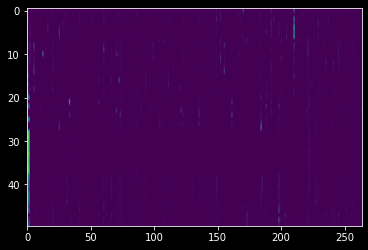

In [24]:
plt.imshow(oof[CFG.class_names].iloc[0:50,:], aspect='auto')

In [25]:
oof.to_csv('oof.csv',index=False)

## save oof

In [22]:
# # Save OOF data to disk
# columns = ['filepath', 'fold', 'true', 'pred', *CFG.class_names]
# df_oof = pd.DataFrame(np.concatenate([ids[:,None], folds, y_true,
#                                       np.argmax(y_pred,axis=1)[:,None], y_pred], axis=1), columns=columns)
# df_oof['class_name'] = df_oof.true.map(CFG.label2name)
# df_oof['miss'] = df_oof.true!=df_oof.pred
# tqdm.pandas(desc='id ')
# df_oof = df_oof.progress_apply(get_id,axis=1)
# df_oof.to_csv('oof.csv',index=False)
# display(df_oof.head(2))

# Error Analysis

In [23]:
# print('Miss Total:')
# display(df_oof.query("miss==True").shape[0])

# print()
# print('Miss Distribution Top10:')
# display(df_oof.query("miss==True").class_name.value_counts()[:10])